# Develop `compare_tide_prediction_max_ssh` Figure Module

Development of functions for `nowcast.figures.publish.compare_tide_prediction_max_ssh` web site figure module.

In [1]:
from datetime import timedelta
from pathlib import Path
from types import SimpleNamespace

import arrow
from matplotlib import gridspec
import matplotlib.dates
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import netCDF4
import numpy
import requests
import xarray

from salishsea_tools import data_tools, viz_tools, wind_tools
from salishsea_tools.places import PLACES

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_get_ssh_forecast()` Function

In [3]:
def _get_ssh_forecast(place, dataset_url_tmpl):
    ## TODO: This is a work-around because neither netCDF4 nor xarray are able
    ## to load the dataset directly from the URL due to an OpenDAP issue
    dataset_url = dataset_url_tmpl.format(place=place.replace(" ", ""))
    dataset_id = dataset_url.rsplit('/', 1)[1]
    ssh_file = Path('/tmp').joinpath(dataset_id).with_suffix('.nc')
    with ssh_file.open('wb') as f:
        resp = requests.get(f'{dataset_url}.nc')
        f.write(resp.content)
    ssh_forecast = xarray.open_dataset(ssh_file)
    return ssh_forecast

## `_prep_plot_data()` Function

In [4]:
def _prep_plot_data(
    place, ssh_fcst_dataset_url_tmpl, tidal_predictions, forecast_hrs, weather_path, bathy, grid_T_hr_path
):
    # NEMO sea surface height forecast dataset
    ssh_forecast = _get_ssh_forecast(place, ssh_fcst_dataset_url_tmpl)
    # CHS water level observations dataset
    try:
        obs_1min = data_tools.get_chs_tides(
            'obs', place,
            arrow.get(str(ssh_forecast.time[0].values)) - timedelta(seconds=5*60),
            arrow.get(str(ssh_forecast.time[-1].values))
        )
        obs_10min_avg = xarray.DataArray(obs_1min.resample('10min', loffset='5min').mean())
        obs = xarray.Dataset({'water_level': obs_10min_avg.rename({'dim_0': 'time'})})
    except TypeError:
        # Invalid tide gauge station number, probably None
        obs = None
    shared.localize_time(ssh_forecast)
    try:
        shared.localize_time(obs)
    except (IndexError, AttributeError):
        # No observations available
        obs = None
    model_ssh_period = slice(str(ssh_forecast.time.values[0]), str(ssh_forecast.time.values[-1]))
    forecast_period = slice(str(ssh_forecast.time.values[-forecast_hrs*6]), str(ssh_forecast.time.values[-1]))
    try:
        obs_period = slice(str(obs.time.values[0]), str(obs.time.values[-1]))
    except AttributeError:
        # No observations available
        obs_period = None
    # Predicted tide water levels dataset from ttide
    ttide = shared.get_tides(place, tidal_predictions)
    ttide.rename(columns={' pred_noshallow ': 'pred_noshallow'}, inplace=True)
    ttide.index = ttide.time
    ttide_ds = xarray.Dataset.from_dataframe(ttide)
    shared.localize_time(ttide_ds, local_datetime=arrow.get(str(ssh_forecast.time.values[0])).to('local'))
    # NEMO sea surface height dataset corrected to include unmodeled tide constituents
    ssh_correction = ttide_ds.pred_noshallow.sel(time=model_ssh_period) - ttide_ds.pred_8.sel(time=model_ssh_period)
    ssh_corrected = ssh_forecast + ssh_correction
    # Mean sea level and extreme water levels
    msl = PLACES[place]['mean sea lvl']
    extreme_ssh = PLACES[place]['hist max sea lvl']
    max_tides = ttide.pred_all.max() + msl
    mid_tides = 0.5 * (extreme_ssh - max_tides) + max_tides
    thresholds = (max_tides, mid_tides, extreme_ssh)
    max_ssh = ssh_corrected.ssh.sel(time=forecast_period)
    max_ssh = max_ssh.where(max_ssh==max_ssh.max(), drop=True).squeeze()
    # Residual differences between corrected model and observations and predicted tides
    model_residual = ssh_corrected - ttide_ds.pred_all.sel(time=model_ssh_period)
    model_residual.attrs['tz_name'] = ssh_forecast.attrs['tz_name']
    max_model_residual = model_residual.max()
    try:
        obs_residual = obs - ttide_ds.pred_all.sel(time=obs_period) - msl
        obs_residual.attrs['tz_name'] = obs.attrs['tz_name']
    except KeyError:
        # No observations available
        obs_residual = None
    # Wind at NEmo model time of max sea surface height
    wind_4h_avg = wind_tools.calc_wind_avg_at_point(
        arrow.get(str(max_ssh.time.values)),
        weather_path,
        PLACES[place]['wind grid ji'],
        avg_hrs=-4
    )
    wind_4h_avg = wind_tools.wind_speed_dir(*wind_4h_avg)
    # Model sea surface height field for contour map
    tracers_ds = xarray.open_dataset(grid_T_hr_path)
    max_ssh_time_utc = arrow.get(
        str(max_ssh.time.values)).replace(tzinfo=ssh_forecast.attrs['tz_name']).to('utc')
    return SimpleNamespace(
        ssh_forecast=ssh_forecast,
        obs=obs,
        ttide=ttide_ds,
        ssh_corrected=ssh_corrected,
        msl=msl,
        thresholds=thresholds,
        max_ssh=max_ssh,
        model_residual=model_residual,
        max_model_residual = max_model_residual,
        obs_residual=obs_residual,
        wind_4h_avg=wind_4h_avg,
        bathy=bathy,
        max_ssh_field=tracers_ds.sossheig.sel(time_counter=max_ssh_time_utc.naive, method='nearest')
    )

## `_prep_fig_axes() Function`

In [5]:
def _prep_fig_axes(figsize, theme):
    fig = plt.figure(
        figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1])
    gs.update(wspace=0.13, hspace=0.2)
    ax_info = fig.add_subplot(gs[0, 0])
    ax_ssh = {'chart_datum': fig.add_subplot(gs[1, 0])}
    ax_ssh['msl'] = ax_ssh['chart_datum'].twinx()
    for axis in ax_ssh.values():
        axis.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    ax_res = fig.add_subplot(gs[2, 0])
    ax_res.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    ax_map = fig.add_subplot(gs[:, 1])
    fig.autofmt_xdate()
    return fig, (ax_info, ax_ssh, ax_map, ax_res)

## `_plot_info_box()` Function

In [6]:
def _plot_info_box(ax_info, place, plot_data, theme):
    ax_info.text(
        0.05,
        0.9,
        place,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax_info.transAxes,
        fontproperties=theme.FONTS['info box title'],
        color=theme.COLOURS['text']['info box title']
    )
    heading = wind_tools.bearing_heading(
        wind_tools.wind_to_from(plot_data.wind_4h_avg.dir)
    )
    texts = (
        SimpleNamespace(
            x=0.05, y=0.75,
            words=(
                f'Max SSH: {numpy.asscalar(plot_data.max_ssh)+plot_data.msl:.2f} '
                f'metres above chart datum')
        ),
        SimpleNamespace(
            x=0.05, y=0.6,
            words=(
                f'Time of max: {arrow.get(str(plot_data.max_ssh.time.values)).format("YYYY-MM-DD HH:mm")} '
                f'{plot_data.ssh_forecast.attrs["tz_name"]}'
            )
        ),
        SimpleNamespace(
            x=0.05, y=0.45,
            words=f'Residual: {numpy.asscalar(plot_data.max_model_residual.ssh):.2f} metres'
        ),
        SimpleNamespace(
            x=0.05, y=0.3,
            words=(
                f'Wind: '
                f'{plot_data.wind_4h_avg.speed:.0f} m/s from the {heading} \n'
                f'(averaged over four hours prior to maximum water level)'
            )
        )
    )
    for text in texts:
        ax_info.text(
            text.x,
            text.y,
            text.words,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax_info.transAxes,
            fontproperties=theme.FONTS['info box content'],
            color=theme.COLOURS['text']['info box content']
        )
    _info_box_hide_frame(ax_info, theme)

## `__info_box_hide_frame()` Function

In [7]:
def _info_box_hide_frame(ax_info, theme):
    ax_info.set_axis_bgcolor(theme.COLOURS['figure']['facecolor'])
    ax_info.xaxis.set_visible(False)
    ax_info.yaxis.set_visible(False)
    for spine in ax_info.spines:
        ax_info.spines[spine].set_visible(False)


## `_plot_ssh_time_series()` Function

In [8]:
def _plot_ssh_time_series(ax_ssh, place, plot_data, theme, ylims=(-1, 6)):
    try:
        plot_data.obs.water_level.plot(
            ax=ax_ssh['chart_datum'],
            linewidth=2,
            label='Observed',
            color=theme.COLOURS['time series']['tide gauge obs']
        )
    except AttributeError:
        # No observations available
        pass
    (plot_data.ttide.pred_all + plot_data.msl).plot(
        ax=ax_ssh['chart_datum'],
        linewidth=2,
        label='Tide Prediction',
        color=theme.COLOURS['time series']['tidal prediction vs model']
    )
    (plot_data.ssh_forecast.ssh + plot_data.msl).plot(
        ax=ax_ssh['chart_datum'],
        linewidth=1,
        linestyle='--',
        label='Model',
        color=theme.COLOURS['time series']['tide gauge ssh']
    )
    (plot_data.ssh_corrected.ssh + plot_data.msl).plot(
        ax=ax_ssh['chart_datum'],
        linewidth=2,
        linestyle='-',
        label='Corrected Model',
        color=theme.COLOURS['time series']['tide gauge ssh']
    )
    ax_ssh['chart_datum'].plot(
        plot_data.max_ssh.time,
        plot_data.max_ssh + plot_data.msl,
        marker='o',
        markersize=10,
        markeredgewidth=3,
        label='Maximum SSH',
        color=theme.COLOURS['marker']['max ssh']
    )
    colors = ['Gold', 'Red', 'DarkRed']
    labels = ['Maximum tides', 'Extreme water', 'Historical maximum']
    for wlev, color, label in zip(plot_data.thresholds, colors, labels):
        ax_ssh['chart_datum'].axhline(
            y=wlev, color=color, lw=2, ls='solid', label=label
        )
    legend = ax_ssh['chart_datum'].legend(
        numpoints=1,
        bbox_to_anchor=(0.75, 1.2),
        loc='lower left',
        borderaxespad=0,
        prop=theme.FONTS['legend label small']
    )
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _ssh_time_series_labels(ax_ssh, place, plot_data, ylims, theme)

## `_ssh_time_series_labels()` Function

In [9]:
def _ssh_time_series_labels(ax_ssh, place, plot_data, ylims, theme):
    ax_ssh['chart_datum'].set_title(
        f'Sea Surface Height at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax_ssh['chart_datum'].grid(axis='both')
    ax_ssh['chart_datum'].set_xlim(
        plot_data.ssh_forecast.time.values[0], plot_data.ssh_forecast.time.values[-1]
    )
    ax_ssh['msl'].set_ylim((ylims[0] - plot_data.msl, ylims[1] - plot_data.msl))
    ylabels = (
        'Water Level above \n Chart Datum [m]', 'Water Level wrt MSL [m]'
    )
    for axis, ylabel in zip(ax_ssh.values(), ylabels):
        axis.set_ylabel(
            ylabel,
            fontproperties=theme.FONTS['axis'],
            color=theme.COLOURS['text']['axis']
        )
        theme.set_axis_colors(axis)

## `_plot_residual_time_series()` Function

In [10]:
def _plot_residual_time_series(ax_res, plot_data, theme):
    plot_data.model_residual.ssh.plot(
        ax=ax_res,
        linewidth=2,
        label='Model Residual',
        color=theme.COLOURS['time series']['ssh residual']
    )
    try:
        plot_data.obs_residual.water_level.plot(
            ax=ax_res,
            linewidth=2,
            label='Observed Residual',
            color=theme.COLOURS['time series']['obs residual']
        )
    except AttributeError:
        # No observations available
        pass
    ax_res.legend()
    _residual_time_series_labels(ax_res, plot_data, theme)

## `_residual_time_series_labels()` Function

In [11]:
def _residual_time_series_labels(ax_res, plot_data, theme, ylims=(-1, 1), yticks=numpy.arange(-1, 1.25, 0.25)):
    ax_res.set_title('')
    ax_res.set_xlabel(
        f'Time [{plot_data.model_residual.attrs["tz_name"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax_res.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d%b %H:%M'))
    ax_res.set_ylabel(
        'Residual [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax_res.set_ylim(ylims)
    ax_res.set_yticks(yticks)
    ax_res.grid(axis='both')
    theme.set_axis_colors(ax_res)

## `_plot_ssh_map()` Function

In [12]:
def _plot_ssh_map(ax_map, plot_data, place, theme):
    contour_intervals = [
        -1, -0.5, 0.5, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.4, 2.6
    ]
    mesh = ax_map.contourf(
        plot_data.max_ssh_field,
        contour_intervals,
        cmap='YlOrRd',
        extend='both',
        alpha=0.6
    )
    ax_map.contour(
        plot_data.max_ssh_field,
        contour_intervals,
        colors='black',
        linestyles='--'
    )
    cbar = plt.colorbar(mesh, ax=ax_map)
    j, i = PLACES[place]['NEMO grid ji']
    ax_map.plot(
        i,
        j,
        marker='o',
        markersize=10,
        markeredgewidth=3,
        color=theme.COLOURS['marker']['place']
    )
    viz_tools.plot_coastline(ax_map, plot_data.bathy)
    viz_tools.plot_land_mask(ax_map, plot_data.bathy, color=theme.COLOURS['land'])
    _ssh_map_axis_labels(ax_map, place, plot_data, theme)
    _ssh_map_cbar_labels(cbar, contour_intervals, theme)

## `_ssh_map_axis_labels()` Function

In [13]:
def _ssh_map_axis_labels(ax_map, place, plot_data, theme):
    tz_name = plot_data.ssh_forecast.attrs["tz_name"]
    ax_map.set_title(
        f'Sea Surface Height at '
        f'{arrow.get(str(plot_data.max_ssh_field.time_counter.values)).to(tz_name).format("YYYY-MM-DD HH:mm")} '
        f'{tz_name}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax_map.yaxis.set_major_formatter(NullFormatter())
    ax_map.grid(axis='both')
    theme.set_axis_colors(ax_map)

## `_ssh_map_cbar_labels()` Function

In [14]:
def _ssh_map_cbar_labels(cbar, contour_intervals, theme):
    cbar.set_ticks(contour_intervals)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        'Water Level wrt MSL [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [15]:
def make_figure(
    place, ssh_fcst_dataset_url_tmpl, tidal_predictions, forecast_hrs,
    weather_path, bathy, grid_T_hr_path,
    figsize=(20, 12), theme=nowcast.figures.website_theme
):
    plot_data = _prep_plot_data(
        place, ssh_fcst_dataset_url_tmpl, tidal_predictions, forecast_hrs,
        weather_path, bathy, grid_T_hr_path
    )
    fig, (ax_info, ax_ssh, ax_map, ax_res) = _prep_fig_axes(figsize, theme)
    _plot_info_box(ax_info, place, plot_data, theme)
    _plot_ssh_time_series(ax_ssh, place, plot_data, theme)
    _plot_residual_time_series(ax_res, plot_data, theme)
    _plot_ssh_map(ax_map, plot_data, place, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()
/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


1min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


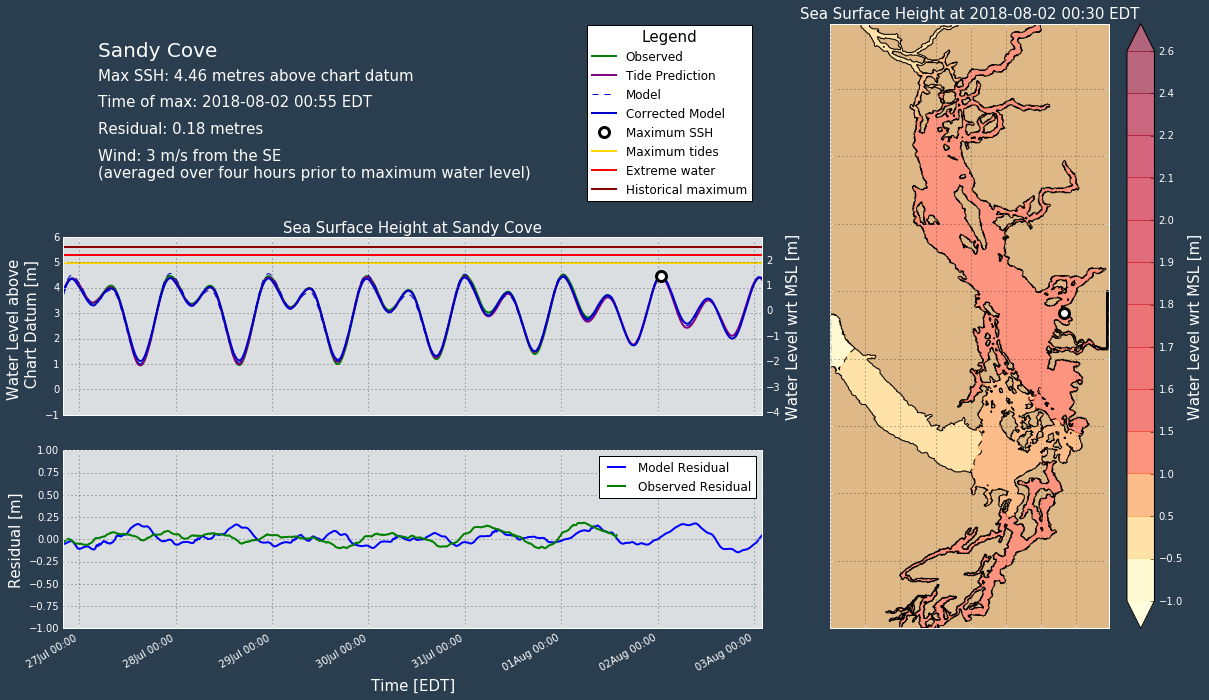

In [16]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(website_theme)
reload(places)

run_type = 'forecast'
ssh_fcst_dataset_url_tmpl = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf{place}SSH10mV17-02'
tidal_predictions = '/SalishSeaCast/tidal-predictions/'
forecast_hrs = int(1.5 * 24) if run_type == 'forecast' else int(1.25 * 24)
weather_path = Path('/results/forcing/atmospheric/GEM2.5/operational/fcst/')
bathy = netCDF4.Dataset(Path('/results/nowcast-sys/grid/bathymetry_201702.nc'))
grid_T_hr_path = Path(f'/results/SalishSea/{run_type}/31jul18/SalishSea_1h_20180801_20180802_grid_T.nc')

fig = make_figure(
    'Sandy Cove', ssh_fcst_dataset_url_tmpl, tidal_predictions, forecast_hrs,
    weather_path, bathy, grid_T_hr_path,
)